## **Identificación De Especies de Mosquitos - Data Science**

Carol Arévalo, Stefano Aragoni, Luis Santos, Diego Perdomo

### *Modelo*

El Ministerio de Salud y Asistencia Social (MSPAS) ha informado que Guatemala ha experimentado un aumento significativo en el número de casos de dengue en 2023, con más de 10,000 casos confirmados y 21 muertes hasta el 12 de agosto. El MSPAS ha declarado una alerta epidemiológica en todo el país para combatir la propagación del dengue (Gobierno De Guatemala, 2023).  


Con esto en mente, el presente proyecto busca utilizar técnicas de procesamiento de imágenes y aprendizaje automático para identificar la especie de mosquito Aedes aegypti a partir de imágenes, con el fin de apoyar los esfuerzos de prevención del dengue en Guatemala.

#### Librerías

Como primer paso, se importan las librerías necesarias para el desarrollo del proyecto.

In [1]:
import os
import tensorflow as tf
import logging
import numpy as np
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Conv2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
tf.get_logger().setLevel(logging.ERROR)

#### Cargas las imagenes

In [2]:
data = pd.read_csv('phase2_train_v0.csv')

#### Preprocesamiento

##### Analizar la Distribución de Clases


In [3]:
class_distribution = data['class_label'].value_counts()
print(class_distribution)

albopictus            4612
culex                 4563
culiseta               622
japonicus/koreicus     429
anopheles               84
aegypti                 47
Name: class_label, dtype: int64


#### Estandarización de Imágenes

In [4]:
input_folder = 'final'
output_folder = 'procesadas'
target_width = 100
target_height = 100

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


    for index, row in tqdm(data.iterrows(), total=data.shape[0]):
        filename = row.img_fName
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)
        img = img.crop((row.bbx_xtl, row.bbx_ytl, row.bbx_xbr, row.bbx_ybr))
        img = img.resize((target_width, target_height), Image.LANCZOS)
        
        img = img.convert("L")
        
        img = np.array(img) / 255.0
        output_path = os.path.join(output_folder, filename)
        img = Image.fromarray((img * 255).astype(np.uint8))
        img.save(output_path)

else:
    print('Las imágenes ya están procesadas')

Las imágenes ya están procesadas


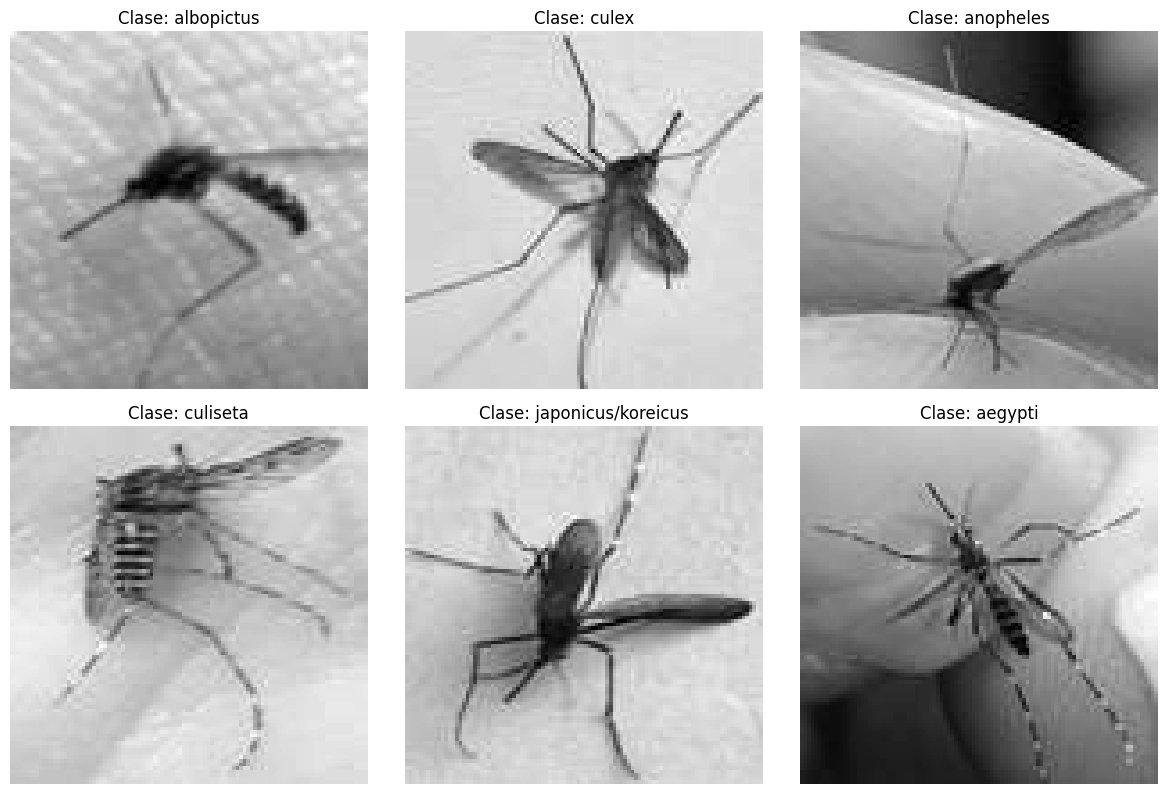

In [5]:
unique_classes = data['class_label'].unique()
num_rows = len(unique_classes) // 3 + 1
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, class_label in enumerate(unique_classes):
    class_data = data[data['class_label'] == class_label]
    first_image_name = class_data.iloc[0]['img_fName']
    image_path = os.path.join(output_folder, first_image_name)
    img = Image.open(image_path)
    
    row = i // num_cols
    col = i % num_cols
    
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(f'Clase: {class_label}')
    axes[row, col].axis('off')

for i in range(len(unique_classes), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

In [6]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

max_images = data['class_label'].value_counts().max()
data_balanced = pd.DataFrame(columns=['img_fName', 'class_label'])
data_balanced = pd.concat([data_balanced, data], ignore_index=True)
unique = data['class_label'].unique()

for class_label in tqdm(unique):
    class_count = sum(data['class_label'] == class_label)
    
    if class_count < max_images:
        num_new_images = max_images - class_count
        class_images = data[data['class_label'] == class_label]['img_fName']
        
        for i, original_image_name in enumerate(class_images):
            img = load_img(os.path.join(output_folder, original_image_name), color_mode='grayscale')
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                i += 1
                if i > num_new_images:
                    break
                
                new_img = array_to_img(batch[0], scale=False)
                new_image_name = f'new_image_{original_image_name.split(".")[0]}_{i}.jpeg'
                new_img.save(os.path.join(output_folder, new_image_name))
                
                new_data = pd.DataFrame({
                    'img_fName': [new_image_name],
                    'class_label': [class_label]
                })
                data_balanced = pd.concat([data_balanced, new_data], ignore_index=True)
                
            if i >= num_new_images:
                break

100%|██████████| 6/6 [00:59<00:00,  9.88s/it]


In [7]:
data_balanced = shuffle(data_balanced)
print(data_balanced['class_label'].value_counts())

data_balanced.to_csv('data_balanced.csv', index=False)

culex                 4612
culiseta              4612
aegypti               4612
japonicus/koreicus    4612
anopheles             4612
albopictus            4612
Name: class_label, dtype: int64


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_balanced,
    directory='procesadas',
    x_col='img_fName',
    y_col='class_label',
    target_size=(target_width, target_height),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=data_balanced,
    directory='procesadas',
    x_col='img_fName',
    y_col='class_label',
    target_size=(target_width, target_height),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 22138 validated image filenames belonging to 6 classes.
Found 5534 validated image filenames belonging to 6 classes.


In [9]:
with open('class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

#### Definición del Modelo

In [12]:
model = Sequential()

# Aplanamos la entrada para que pueda ser alimentada a las capas densas
model.add(Flatten(input_shape=(target_width, target_height, 3)))

# Primera capa densa con 512 unidades y función de activación ReLU
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Dropout para regularización

# Segunda capa densa con 256 unidades y función de activación ReLU
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Dropout para regularización

# Tercera capa densa con 128 unidades y función de activación ReLU
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Dropout para regularización

# Capa de salida con 6 unidades (número de clases de mosquitos) y función de activación softmax
model.add(Dense(6, activation='softmax'))

# Compilamos el modelo
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


##### Compilación del modelo

In [13]:
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#### Entrenamiento

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(filepath="best_model3.h5", verbose=1, save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[early_stop, checkpointer]
)

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 2.1799 - accuracy: 0.3076
Epoch 1: val_loss improved from inf to 1.97628, saving model to best_model3.h5
200/200 [==============================] - 67s 336ms/step - loss: 2.1799 - accuracy: 0.3076 - val_loss: 1.9763 - val_accuracy: 0.4231
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 2.0632 - accuracy: 0.3090
Epoch 2: val_loss improved from 1.97628 to 1.86908, saving model to best_model3.h5
200/200 [==============================] - 66s 331ms/step - loss: 2.0632 - accuracy: 0.3090 - val_loss: 1.8691 - val_accuracy: 0.4437
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 1.9418 - accuracy: 0.3250
Epoch 3: val_loss improved from 1.86908 to 1.81075, saving model to best_model3.h5
200/200 [==============================] - 66s 332ms/step - loss: 1.9418 - accuracy: 0.3250 - val_loss: 1.8107 - val_accuracy: 0.4338
Epoch 4/20
200/200 [==============================] - ETA: 0s - l

#### Resultados del Modelo

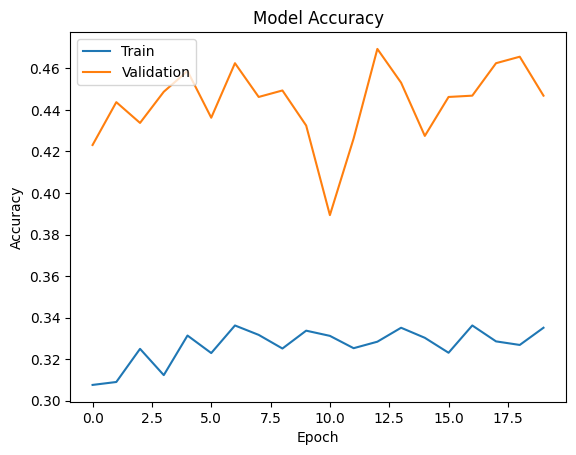

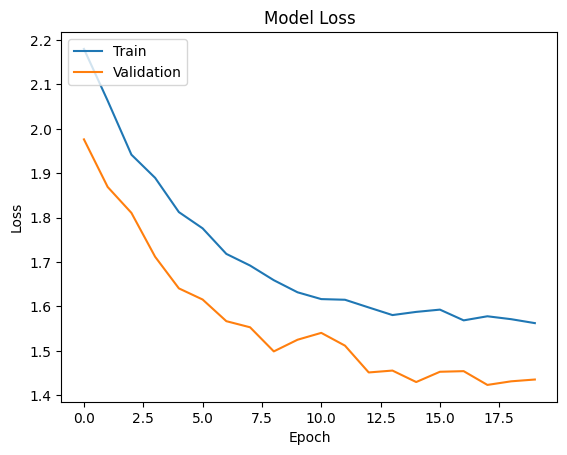

In [16]:
# Precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Matriz de Confusión

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Carga el modelo
model = tf.keras.models.load_model('best_model3.h5')

# 2. Usa el conjunto de validación para predecir las clases de las imágenes
# Nota: es probable que necesites ajustar los parámetros del método predict dependiendo de cómo configuraste tu ImageDataGenerator
predictions = model.predict(validation_generator, steps=validation_generator.n // validation_generator.batch_size + 1)

predicted_classes = np.argmax(predictions, axis=1)

# Las clases verdaderas
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())   

# 3. Comparar las clases predichas con las verdaderas clases para construir la matriz de confusión
confusion_mtx = confusion_matrix(true_classes, predicted_classes) 

# Visualización
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(true_classes, predicted_classes, target_names=class_labels))


#### Validacion con imagen 

In [17]:
def predict_mosquito_type(model, img_path):
    """
    Predicts the type of mosquito based on an image.

    Parameters:
        model : tensorflow.keras.Model
            The trained model to use for prediction.
        img_path : str
            Path to the image file to predict.
    """
    img = image.load_img(img_path, target_size=(target_width, target_height))

    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    img_array = image.img_to_array(img) / 255.
    img_batch = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_batch)
    predicted_index = np.argmax(prediction)

    labels = (train_generator.class_indices)
    labels = dict((v, k) for k, v in labels.items())  # flip the key, values in the dictionary

    predicted_label = labels[predicted_index]
    print(f"Prediction: {predicted_label} ({100*np.max(prediction):.2f}%)")

    return predicted_label

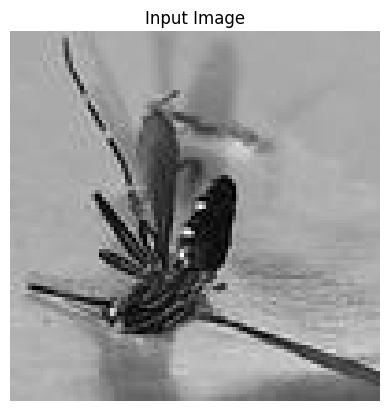

1/1 [==============================] - 0s 124ms/step
Prediction: japonicus/koreicus (20.62%)


'japonicus/koreicus'

In [18]:
predict_mosquito_type(model, "prueba.jpeg")